In [157]:
# !pip install -q xgboost --upgrade

In [158]:
# !pip install -q openfe

In [159]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import lightgbm as lgbm
import statistics
from sklearn.linear_model import Ridge
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from functools import partial
from openfe import OpenFE, transform
import warnings

warnings.filterwarnings('ignore')


In [160]:
# sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [161]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [162]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "Rings"    
    SKEW_THRESHOLD = 0.5
    EARLY_STOPPING = 500
    RESULTS_FILE = "model_execution_results.pkl"
    MODEL_TYPE = enums.ModelName.LGBM
    REMOVE_OUTLIERS = False
    POWER_TRANSFORM = False
    NORMALIZE_DATA = True
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSLE
    NUM_TUNING_TRIALS = 40
    TUNE_ON_SINGLE_FOLD = True
    GENERATE_AUTO_FEATURES = False

COLS_TO_LEAVE = ["Rings", "kfold"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./data/"
if Config.RUN_MODE == "KAGGLE":
    # If we are not generating features, we are using already generated features
    if Config.GENERATE_AUTO_FEATURES:
        DATA_READPATH = "/kaggle/input/playground-series-s4e4/"
    else:
        DATA_READPATH = "/kaggle/input/abalone-openfe/"
    DATA_WRITEPATH = "/kaggle/working/"

In [ ]:
xgb_params_static = {
    "objective": "reg:squarederror",
    "eval_metric": "rmsle",
    "seed": Config.RANDOM_SEED,
    "verbosity": 0,
}
lgbm_params_static = {
        "objective": "mean_squared_error",
        "metric": None,
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    }

params_static = lgbm_params_static

In [164]:
# import train dataset locally from data folder
df_train = pd.read_csv(DATA_READPATH + "train_openfe_20.csv")
# import test dataset locally from data folder
df_test = pd.read_csv(DATA_READPATH + "test_openfe_20.csv")
# drop id column
#df_train = df_train.drop("id", axis=1)
#df_test = df_test.drop("id", axis=1)
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [165]:
feature_cols_for_fe = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [166]:
def generate_new_features(df_train, df_test, feature_cols, NUM_NEW_FEATURES=10):
    train_X = df_train[feature_cols] 
    test_X = df_test[feature_cols]   
    train_y = df_train[Config.TARGET_COL_NAME]
    ofe = OpenFE()
    features = ofe.fit(data=train_X, label=train_y, n_jobs=CPU_COUNT, verbose=False)  # generate new features
    # OpenFE recommends a list of new features. We include the top 10
    # generated features to see how they influence the model performance
    train_X, test_X = transform(train_X, test_X, ofe.new_features_list[:NUM_NEW_FEATURES], n_jobs=CPU_COUNT)
    return train_X, test_X

In [167]:
if Config.GENERATE_AUTO_FEATURES:
    df_train, df_test = generate_new_features(df_train, df_test, feature_cols_for_fe)    
    df_train_labels = df_train_orig[[Config.TARGET_COL_NAME]]
    # Add the label data to the dataframe
    df_train = pd.concat([df_train, df_train_labels], axis=1)
    # save the new train and test data with openfe features to csv files for later use
    df_train.to_csv(DATA_WRITEPATH + "train_openfe.csv", index=False)
    df_test.to_csv(DATA_WRITEPATH + "test_openfe.csv", index=False)

In [168]:
cols_float = df_train.select_dtypes(include=["float"]).columns.to_list()
cols_int = df_train.select_dtypes(include=["int64"]).columns.to_list()
cols_str = df_train.select_dtypes(include=["object"]).columns.to_list()
feature_cols_to_normalize = cols_float

In [169]:
df_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,autoFE_f_0,autoFE_f_1,autoFE_f_2,autoFE_f_3,autoFE_f_4,autoFE_f_5,autoFE_f_6,autoFE_f_7,autoFE_f_8,autoFE_f_9,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,2.291667,1.368750,1.791667,2.348554,0.3100,0.4430,0.3900,2637.0,0.2400,0.1900,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,1.968750,1.431250,1.531250,2.467249,0.3100,0.6720,0.4650,1173.0,0.3200,0.1700,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,32.000000,1.100000,22.000000,3.818182,0.1550,0.0155,0.0300,487.0,0.0050,0.1050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,2.380000,1.502000,1.900000,2.435419,0.3450,0.5390,0.4000,2088.0,0.2500,0.2250,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,2.810127,1.870886,2.151899,2.116373,0.3575,0.4125,0.3275,32.0,0.1975,0.2275,9


In [170]:
df_train = cv_split_utils.strat_kfold_dataframe(
                                    df=df_train, 
                                    target_col_name=Config.TARGET_COL_NAME, 
                                    num_folds=Config.NUM_FOLDS,
                                    random_state=Config.RANDOM_SEED
                                )
df_train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,autoFE_f_0,autoFE_f_1,autoFE_f_2,autoFE_f_3,autoFE_f_4,autoFE_f_5,autoFE_f_6,autoFE_f_7,autoFE_f_8,autoFE_f_9,Rings,kfold
0,I,0.490,0.380,0.125,0.5290,0.2165,0.1375,0.1550,3.161290,1.396774,2.451613,2.443418,0.3350,0.3125,0.2800,774.0,0.1550,0.2250,7,3
1,I,0.420,0.345,0.100,0.3705,0.1625,0.0795,0.1025,4.097561,1.585366,3.365854,2.280000,0.3175,0.2080,0.2025,148.0,0.1025,0.2425,7,3
2,M,0.555,0.440,0.135,0.7390,0.3515,0.1575,0.2350,2.361702,1.495745,1.872340,2.102418,0.3200,0.3875,0.3700,1311.0,0.2350,0.2050,9,0
3,F,0.535,0.410,0.140,0.7090,0.2505,0.1700,0.1900,2.815789,1.318421,2.157895,2.830339,0.3450,0.4585,0.3300,1017.0,0.1900,0.2200,9,4
4,F,0.605,0.455,0.150,1.0590,0.4275,0.2210,0.3100,1.951613,1.379032,1.467742,2.477193,0.2950,0.6315,0.4600,1020.0,0.3100,0.1450,10,2


In [173]:
def preprocess_features(df, features_to_preprocess):
    float_outliers = []
    for col_name in features_to_preprocess:
        df, df_col_outliers = data_utils.process_outliers_iqr(df, col_name, Config.REMOVE_OUTLIERS)
        df_float_outliers = float_outliers.append(df_col_outliers)
        if Config.POWER_TRANSFORM:
            df, transformed = data_utils.power_transform(df, col_name, Config.SKEW_THRESHOLD)
    df_float_outliers = pd.concat(float_outliers, axis=0)        
    df_float_outliers = df_float_outliers.reset_index(drop=True)
    return df, df_float_outliers

In [174]:
# Preprocess float features for train and test data
df_train, df_train_float_outliers = preprocess_features(df_train, cols_float)
_, df_test_float_outliers = preprocess_features(df_test, cols_float)

In [175]:
# one hot encoding of categorical variables
df_train_onehot = pd.get_dummies(df_train, columns=cols_str)
df_test_onehot = pd.get_dummies(df_test, columns=cols_str)

if Config.NORMALIZE_DATA:
    # normalize
    df_train_onehot = tt.normalize_features(df_train_onehot, 
                                            scaler=Config.SCALER,
                                            features_to_normalize=feature_cols_to_normalize)
    df_test_onehot = tt.normalize_features(df_test_onehot,
                                           scaler=Config.SCALER, 
                                           features_to_normalize=feature_cols_to_normalize)

In [176]:
feature_cols= [x for x in df_train_onehot.columns.to_list() if x not in COLS_TO_LEAVE]
print(feature_cols)

['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'autoFE_f_0', 'autoFE_f_1', 'autoFE_f_2', 'autoFE_f_3', 'autoFE_f_4', 'autoFE_f_5', 'autoFE_f_6', 'autoFE_f_7', 'autoFE_f_8', 'autoFE_f_9', 'Sex_F', 'Sex_I', 'Sex_M']


In [178]:
def get_lgbm_tuning_params(trial):    
    params_dynamic = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=25),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'num_leaves': trial.suggest_int('num_leaves', 4, 128, step=4),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100)
    }
    return {**lgbm_params_static, **params_dynamic}

In [179]:
def get_model_tuning_params(trial, model_name):
    if model_name == enums.ModelName.Ridge:
        return {
            "alpha": trial.suggest_float("alpha", 1e-4, 1e4, log=True)
        }
    if model_name == enums.ModelName.Lasso:
        return {
            "alpha": trial.suggest_float("alpha", 1e-4, 1e4, log=True)
        }
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 400, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.XGBoost:
        xgb_params_dynamic = {            
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 32),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 100, 500, step=20)
        }
        return {**xgb_params_static, **xgb_params_dynamic}
    if model_name == enums.ModelName.LGBM:
        return get_lgbm_tuning_params(trial)

In [180]:
def hyperparams_tuning_objective(trial, model_name, df_train,  
                                 feature_cols, metric, target_col_name, single_fold=False,
                                 num_folds=5, val_preds_col="val_preds"):           
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, df_val_preds = tt.run_training(
        model_name=model_name,
        df_train=df_train,
        target_col_name=target_col_name,
        feature_col_names=feature_cols,
        metric=metric,            
        num_folds=num_folds,
        model_params=model_params,
        val_preds_col=val_preds_col,
        single_fold=single_fold,
        suppress_print=True
    )       
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [181]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      df_train,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5, val_preds_col="val_preds"):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        df_train=df_train,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds,
        val_preds_col=val_preds_col
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [182]:
tuned_model_params = tune_model_params(
                        study_name=Config.MODEL_TYPE + "_ModelTuning", 
                        study_direction="minimize",
                        num_trials=Config.NUM_TUNING_TRIALS,
                        model_name=Config.MODEL_TYPE,
                        df_train=df_train_onehot,
                        feature_cols=feature_cols,
                        metric=Config.METRIC,
                        target_col_name=Config.TARGET_COL_NAME,
                        single_fold=Config.TUNE_ON_SINGLE_FOLD,
                        num_folds=Config.NUM_FOLDS                         
                )

In [184]:
model_params = {**params_static, **tuned_model_params}

In [185]:
fold_metrics_model = tt.train_model(
                            df = df_train_onehot,
                            model_name=Config.MODEL_TYPE,
                            model_params = model_params,
                            feature_col_names = feature_cols,
                            target_col_name = Config.TARGET_COL_NAME,
                            metric = Config.METRIC,
                            num_folds = Config.NUM_FOLDS,
                            single_fold = False,
                            persist_model = True,
                            output_path = DATA_WRITEPATH
                        )


training XGBoost
fold 0 metric = 0.14680924147197982
fold 1 metric = 0.14727438373407215
fold 2 metric = 0.14676284256301225
fold 3 metric = 0.14766762040633652
fold 4 metric = 0.14647533346228903
Saved validation data predictions to df_val_preds_XGBoost.csv
XGBoost CV score = 0.14699848902105286


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

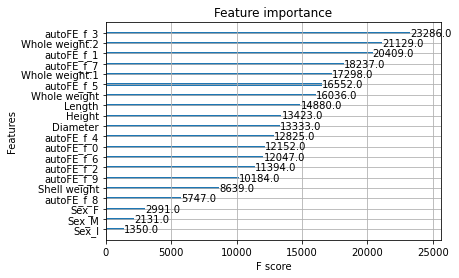

In [186]:
if Config.MODEL_TYPE == enums.ModelName.XGBoost:
    xgb.plot_importance(booster=fold_metrics_model[0][1])
elif Config.MODEL_TYPE == enums.ModelName.LGBM:
    lgbm.plot_importance(fold_metrics_model[0][1])

#### Prediction on test set

In [187]:
df_train["Rings_pred"] = 0.0
test_preds = {}
for fold in range(Config.NUM_FOLDS):
    model = fold_metrics_model[fold][1]
    train_df, val_df = tt.get_fold_df(df_train_onehot, fold) 
    test_df = df_test_onehot[feature_cols]     
    # add the validation predictions for the fold to a new column in train data
    fold_val_preds = model.predict(val_df[feature_cols])
    fold_test_preds = model.predict(test_df)
    df_train.loc[df_train.kfold == fold, "val_preds"] = fold_val_preds
    pred_col_name = f"fold_{fold}_test_preds"
    test_preds[pred_col_name] = fold_test_preds 

In [188]:
df_test_preds = pd.DataFrame(test_preds)
test_pred_cols = [f"fold_{fold}_test_preds" for fold in range(Config.NUM_FOLDS)]
df_test_preds["mean_test_pred"] = df_test_preds[test_pred_cols].mean(axis=1)
df_test_preds["mean_test_pred_rounded"] = np.round(df_test_preds["mean_test_pred"]).astype(int)
print(f"Completed prediction for {len(df_test)} test rows")
df_submission = pd.read_csv(DATA_READPATH + 'sample_submission.csv')
#df_submission['Rings']= df_test_preds["mean_test_pred_rounded"]
df_submission['Rings']= df_test_preds["mean_test_pred"]
df_submission.to_csv(DATA_WRITEPATH + f'submission_{Config.MODEL_TYPE}.csv',index=False)
df_test_preds.to_csv(DATA_WRITEPATH + 'test_preds.csv',index=False)
df_submission.head()

Completed prediction for 60411 test rows


,id,Rings
0,90615,9.586962
1,90616,9.830299
2,90617,9.570453
3,90618,10.593846
4,90619,7.582582
